# Tutorial Geomagnetic Field Inversions
This is a tutorial for using the Geomagnetic Field Inversions code written by Frenk Out, Liz van Grinsven, Monika Korte, and Lennart de Groot. This tutorial will guide you through the following process:
1. Loading data
2. Starting the model
    1. Initiating a FieldInversion class and prepare inversion
    2. Run a time-dependent standard iterative inversion
    3. Plotting results
3. Sweeping through models to find optimal damping parameters (optional)

### 0. Loading libraries
This tutorial requires, besides geomagnetic_field_inversions, numpy, pandas, pathlib, matplotlib, and cartopy. The geomagnetic_field_inversions code consists of three files:
1. StationData is a class that prepares geomagnetic field data to be inputted in FieldInversion later.
2. FieldInversion is the main class where all calculations happen.
3. plot_tools is a plotting module that helps to create frequently used plots in a easy way.

In [2]:
import numpy as np
# Necessary for loading excel/csv files and creating DataFrames
import pandas as pd
# Necessary for correct path handling
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
# Cartopy is only required for plotting world maps
import cartopy.crs as ccrs

# Our code
%load_ext autoreload
%autoreload 2
from geomagnetic_field_inversions import plot_tools, InputData, FieldInversion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Loading and Fitting data
#### Set-up
We will now proceed to loading the data. This is required to run the inversion later. The basic input for adding and fitting the data is a Pandas DataFrame. The DataFrame needs at least a column with latitude (lat; between -90 and 90 degrees), longitude (lon; between 0 and 360 degrees), time (t) of datum, and then data in the form of inclination (I), declination (D), intensity (F), X (X), Y (Y), Z (Z), or H (H) components. Additionally, errors can be appointed to each datatype (dI and dD (or alpha95), dF, dX, dY, dZ, dH).

We start by loading `multi_station.xlsx` and transform that into a usable Pandas DataFrame.

#### *InputData and read_data*
First we initiate a InputData-class to store all data for every location. After that, we add data belonging to that station separately (from the spreadsheet) and expected error (100 nT error for intensity, 1 degree error for both inclination and declination). First for one station.

In [3]:
# initiate class
inputdata = InputData()

# Set a path to load and save files
# path should be like: .../geomagnetic_field_inversions/doc
path = Path().absolute()
# create output folder
Path(path / 'output').mkdir(parents=True, exist_ok=True)
# location of our 'mock' dataset
excel = pd.ExcelFile(path / 'multi_station.xlsx')

# convert to usable format
sheet = pd.read_excel(excel, 'Station 1')
sheet.replace({'lat': np.nan}, sheet.loc[0, 'lat'], inplace=True)
sheet.replace({'lon': np.nan}, sheet.loc[0, 'lon'], inplace=True)
sheet.drop(sheet.columns[[2, 4]], axis=1, inplace=True)
sheet['dF'] = 100
sheet['dI'] = 1
sheet['dD'] = 1
ren_dict = {'time':'t', 'intensity':'F', 'inclination':'I', 'declination':'D'}
sheet.rename(ren_dict, inplace=True, axis='columns')
# add data
inputdata.read_data(sheet)

Now we also add data of other locations. Note that it would also be possible to load all data in one DataFrame at once.

In [4]:
# Now we fit the rest
for nr in range(2, 37):
    sheet = pd.read_excel(excel, sheet_name=f'Station {nr}')
    sheet.replace({'lat': np.nan}, sheet.loc[0, 'lat'], inplace=True)
    sheet.replace({'lon': np.nan}, sheet.loc[0, 'lon'], inplace=True)
    sheet.drop(sheet.columns[[2, 4]], axis=1, inplace=True)
    sheet['dF'] = 100
    sheet['dI'] = 1
    sheet['dD'] = 1
    ren_dict = {'time':'t', 'intensity':'F', 'inclination':'I', 'declination':'D'}
    sheet.rename(ren_dict, inplace=True, axis='columns')
    inputdata.read_data(sheet)

In [5]:
# After loading all data, we need to compile the dataset.
inputdata.compile_data(verbose=True)

Data from t=-8000 to t=1990
This dataset contains 244773 records from 36 locations.
It consists of 81591 declinations, 81591 inclinations and 81591 intensities, 0 x-data, 0 y-data, 0 z-data, and 0 h-data.


Our data is now ready to be used for the geomagnetic field inversion

## 2. Starting the model
### 2. Initiate a FieldInversion class and prepare inversion
#### *FieldInversion*
The `FieldInversion`-class is the 'location' where we will perform all calculations. We start a FieldInversion class by calling
- `MyInstance = FieldInversion(t_min=-8000, t_max=1990, t_step=39.80, maxdegree=3, verbose=True)` 

The t_min, t_max, and t_step determine the time array oer which we model. We set our maximum spherical degree to 3; the verbosity flag helps us to understand what is going on in the code.

More parameters can be changed, but we will not do that for now.

&rarr; For more info about other parameters of this class, type:
`FieldInversion?`

In [56]:
# input modeled time array; from 3000 to 17000 with steps of 100 yr
test_inv = FieldInversion(t_min=-8000, t_max=1990, t_step=39.8007968127486, maxdegree=3, verbose=True)

After we have set up the class, we can proceed to preparing the matrices for our geomagnetic field inversion.
#### *prepare_inversion*
This method is used to add our previously gathered data and determine the spatial and temporal damping type we want to apply.
For these purposes we need at least one parameter:
- d_inst: the class containing the data (`input_data` in our case)
The other 4 optional parameters determine damping:
- spat_type: string indicating the type of spatial damping
- temp_type: string indicating the type of temporal damping
- spat_ddip: boolean indicating whether to damp the dipole coefficients (default to False: no damping)
- temp_ddip: boolean indicating whether to damp the dipole coefficients (defaults to True: yes damping)

Spatial damping enforces that higher order Gauss coefficients do not become too large, while temporal damping enforces a smoothness condition on the individual Gauss coefficients through time.

We will use 'Gubbins'-like (ohmic_heating) spatial damping (3). For the temporal damping we will minimize the acceleration of the magnetic field at the cmb ('min_acc'). For more info on the implemented damping types, please have a look at `damping_modules/damp_types.py`.

In [57]:
test_inv.prepare_inversion(inputdata, spat_type='ohmic_heating', temp_type='min_acc')

Calculating Schmidt polynomials and Fréchet coefficients
Calculating spatial damping matrix
Calculating temporal damping matrix
Calculations finished


### B. Run a time-dependent standard iterative inversion
#### *run_inversion*
Now we have prepared everything for the inversion. We can now proceed to starting the iterative inversion by using the `run_inversion`-method. This method requires a starting model and damping parameters. We will use a starting model with where only $g_1^0$ has a value of 30000. For our spatial damping we use a value of 5e-13, for temporal damping 1e-1. Normally, you would find the optimal damping parameters by sweeping through a range of damping parameters and find a combination that both minimizes the residual and the damping energy (dependent on Gauss coefficient)

we also set the maximum amount of iterations to 10, but always check whether the model converged sufficiently (see plot_residuals). Additionally, by providing a path you could store the normal matrices to construct a covariance matrix (and obtain standard deviations) later.

In [58]:
# our starting model should be as long as the number of gaussian coefficients up to degree 3, i.e. 15 coefficients.
x0 = np.zeros(15)
# you could also make use of the attribute _nr_coeffs to do this automatically:
# x0 = np.zeros(test_inv._nr_coeffs)
x0[0] = 30000
test_inv.run_inversion(x0, max_iter=10, spat_damp=5e-13, temp_damp=1e-1)

Setting up starting model
Start calculations iteration 0
Residual is 44.83
Prepare and solve equations
Start calculations iteration 1
Residual is 6.26
Prepare and solve equations
Start calculations iteration 2
Residual is 4.49
Prepare and solve equations
Start calculations iteration 3
Residual is 4.44
Prepare and solve equations
Start calculations iteration 4
Residual is 4.43
Prepare and solve equations
Start calculations iteration 5
Residual is 4.43
Prepare and solve equations
Start calculations iteration 6
Residual is 4.43
Prepare and solve equations
Start calculations iteration 7
Residual is 4.43
Prepare and solve equations
Start calculations iteration 8
Residual is 4.43
Prepare and solve equations
Start calculations iteration 9
Residual is 4.43
Prepare and solve equations
Start calculations iteration 10
Residual is 4.43
Final iteration; relative error = 1.95904590992687e-06
Calculating optional spatial and temporal norms
Spatial damping norm: 58693739990.553246
Temporal damping nor

After each iteration, the rms residual is shown and how many datapoins are rejected. After 3 iterations the residual does not change much.

#### *save_spherical_coefficients*
We will now proceed to saving our final coefficients by inputting a path and name to save our files; we save the residuals by setting `save_residual=True`. This will create a *Tutorial_residual.csv*-file containing all residuals after each timestep. Additionally, we save the final Gauss coefficients of the final iteration, per timestep, unsplined. The gaussian coefficients are stored degree-wise, so: $g_1^0$, $g_1^1$, $h_1^1$, $g_2^0$, $g_2^1$, $h_2^1$, $g_2^2$, $h_2^2$, etc ...

In [10]:
test_inv.save_coefficients(path / 'output', file_name='Tutorial', save_residual=True)

### C. Plotting Results
After running the inversion, we will obtain plots of the results to investigate what is going on in our model. For that purpose, we will plot residuals, powerspectra, and coefficients

#### residuals plots
by calling `plot_tools.plot_residuals` we can easily create a plot that shows the residuals of the various datatypes per iteration. The figure shows in this case that after 3-4 iterations the residual seems stable.

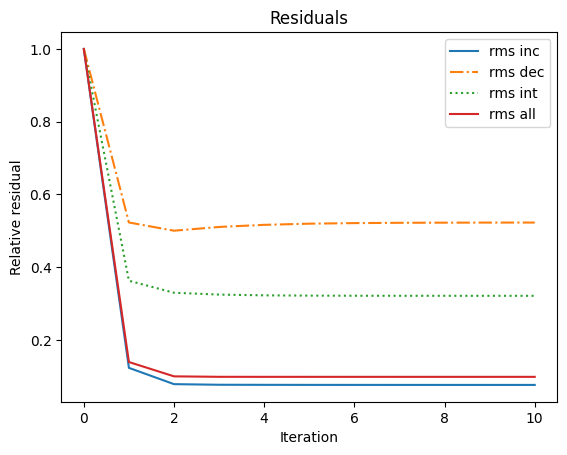

In [47]:
# We start by plotting the rms of various types per iteration
# start a figure
fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative residual')
# make a call to the plotting library, input ax and our FieldInversion instance
ax = plot_tools.plot_residuals(ax, test_inv)
ax.legend(loc='upper right')
plt.show()

#### powerspectra
The `plot_tools.plot_spectrum` allows the plotting of the powerspectrum and secular variation of the gaussian coefficients. The default option is to plot the energy 'stored' in each degree. If the `cmb`-parameter is set to True, the two plots show the powerspectrum and secular variation at the core mantle boundary.

It is also possible to plot the powerspectrum and secular variation at a different time interval.

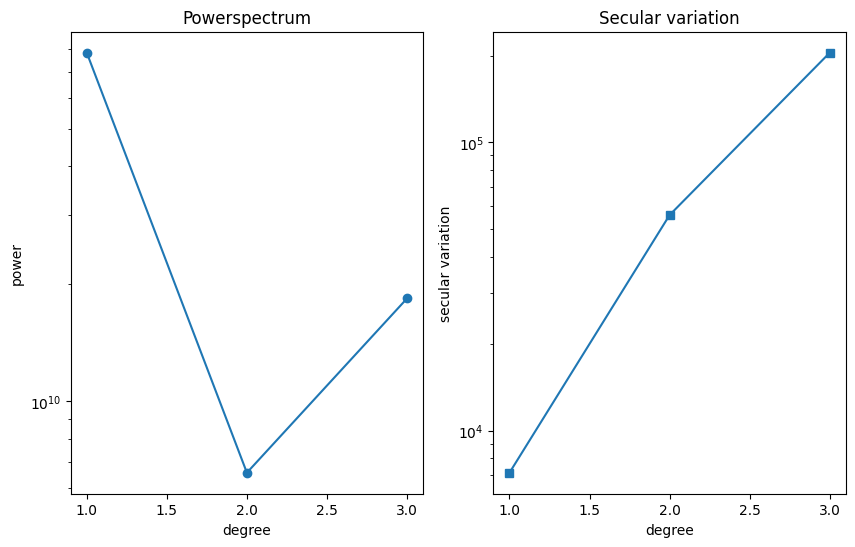

In [48]:
# start figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title('Powerspectrum')
axes[0].set_xlabel('Spherical degree l')
axes[0].set_ylabel('Power')
axes[1].set_title('Secular variation')
axes[1].set_xlabel('Spherical degree l')
axes[1].set_ylabel('Secular variation')
# make a call to the plotting library
axes = plot_tools.plot_spectrum(axes, test_inv)
plt.show()

#### damping norms
The `plot_tools.plot_dampnorm` enables the plotting of the spatial/temporal damping norm through time. First we plot the spatial damping norm, then the temporal damping norm is plotted by setting `spatial=False`.

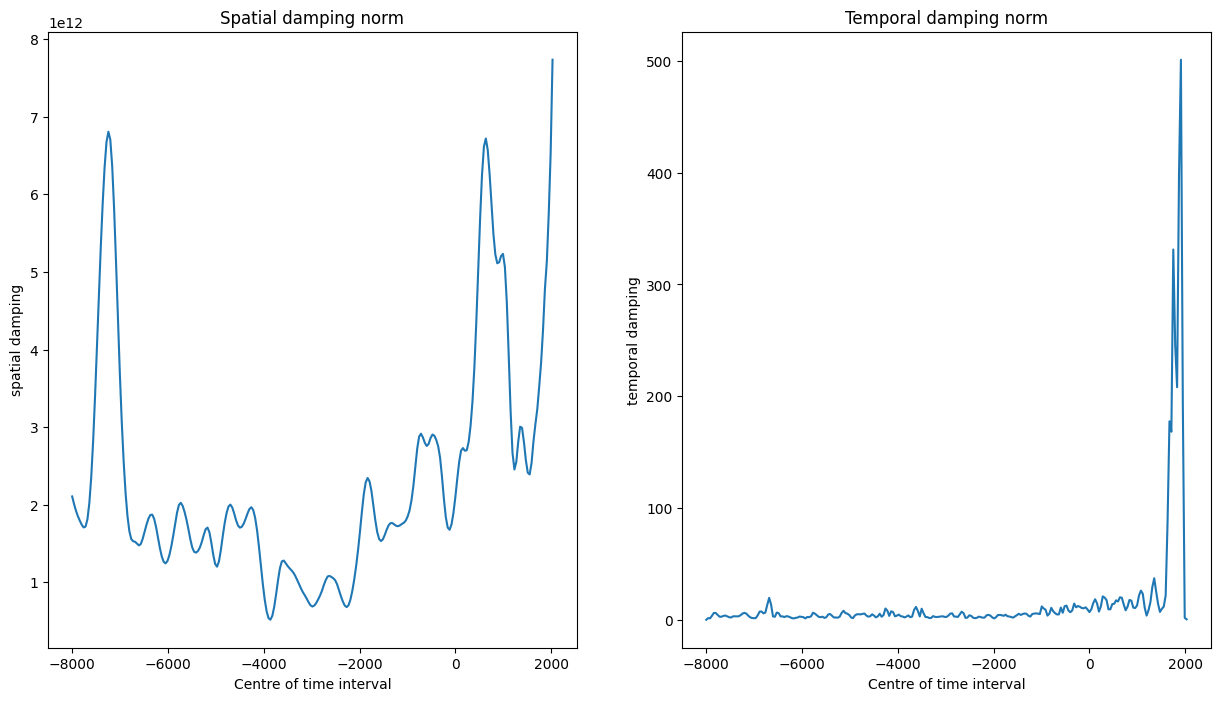

In [59]:
# start figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].set_title('Spatial damping norm')
axes[0] = plot_tools.plot_dampnorm(axes[0], test_inv)
axes[1].set_title('Temporal damping norm')
axes[1] = plot_tools.plot_dampnorm(axes[1], test_inv, spatial=False)
plt.show()

#### Gauss coefficients
By using `plot_tools.plot_coeff` we can plot the gaussian coefficients through time. It plots all gaussian coefficients of the same degree at once, but we could also decide to define yourself which coefficients to plot by setting `index` (see `plot_tools.plot_coeff`). It defaults to using the coefficients calculated in the last iteration, but we could choose otherwise by setting `it_time` to something else than -1.

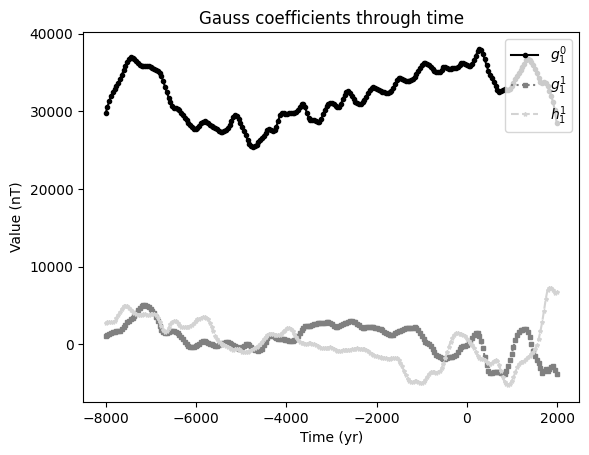

In [50]:
fig, ax = plt.subplots()
ax.set_title('Gauss coefficients through time')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Value (nT)')
# we only want to plot gaussian coefficients of degree 1
ax = plot_tools.plot_coeff(ax, test_inv, degree=1)
ax.legend(loc='upper right')
plt.show()

We can also plot the Gauss coefficients per iteration, in order to do that we set `plot_iter=True`:

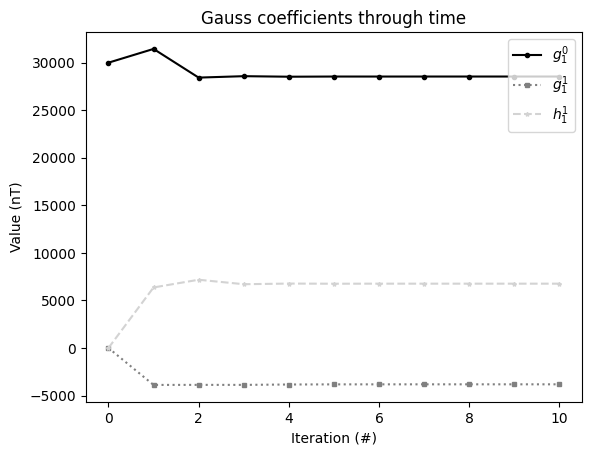

In [52]:
fig, ax = plt.subplots()
ax.set_title('Gauss coefficients through time')
ax.set_xlabel('Iteration (#)')
ax.set_ylabel('Value (nT)')
# we only want to plot gaussian coefficients of degree 1
ax = plot_tools.plot_coeff(ax, test_inv, degree=1, plot_iter=True)
ax.legend(loc='upper right')
plt.show()

Already after 3 iterations, the Gauss coefficients are stable

#### forward calculations
After calculation of the gaussian coefficients, we plot their effect on a worldmap and on one location. For the worldmap, we define 3 axes and choose a projection. We choose a time we want to plot and indicate if we want to plot the magnetic field at the cmb (`cmb=True`) or not (default).

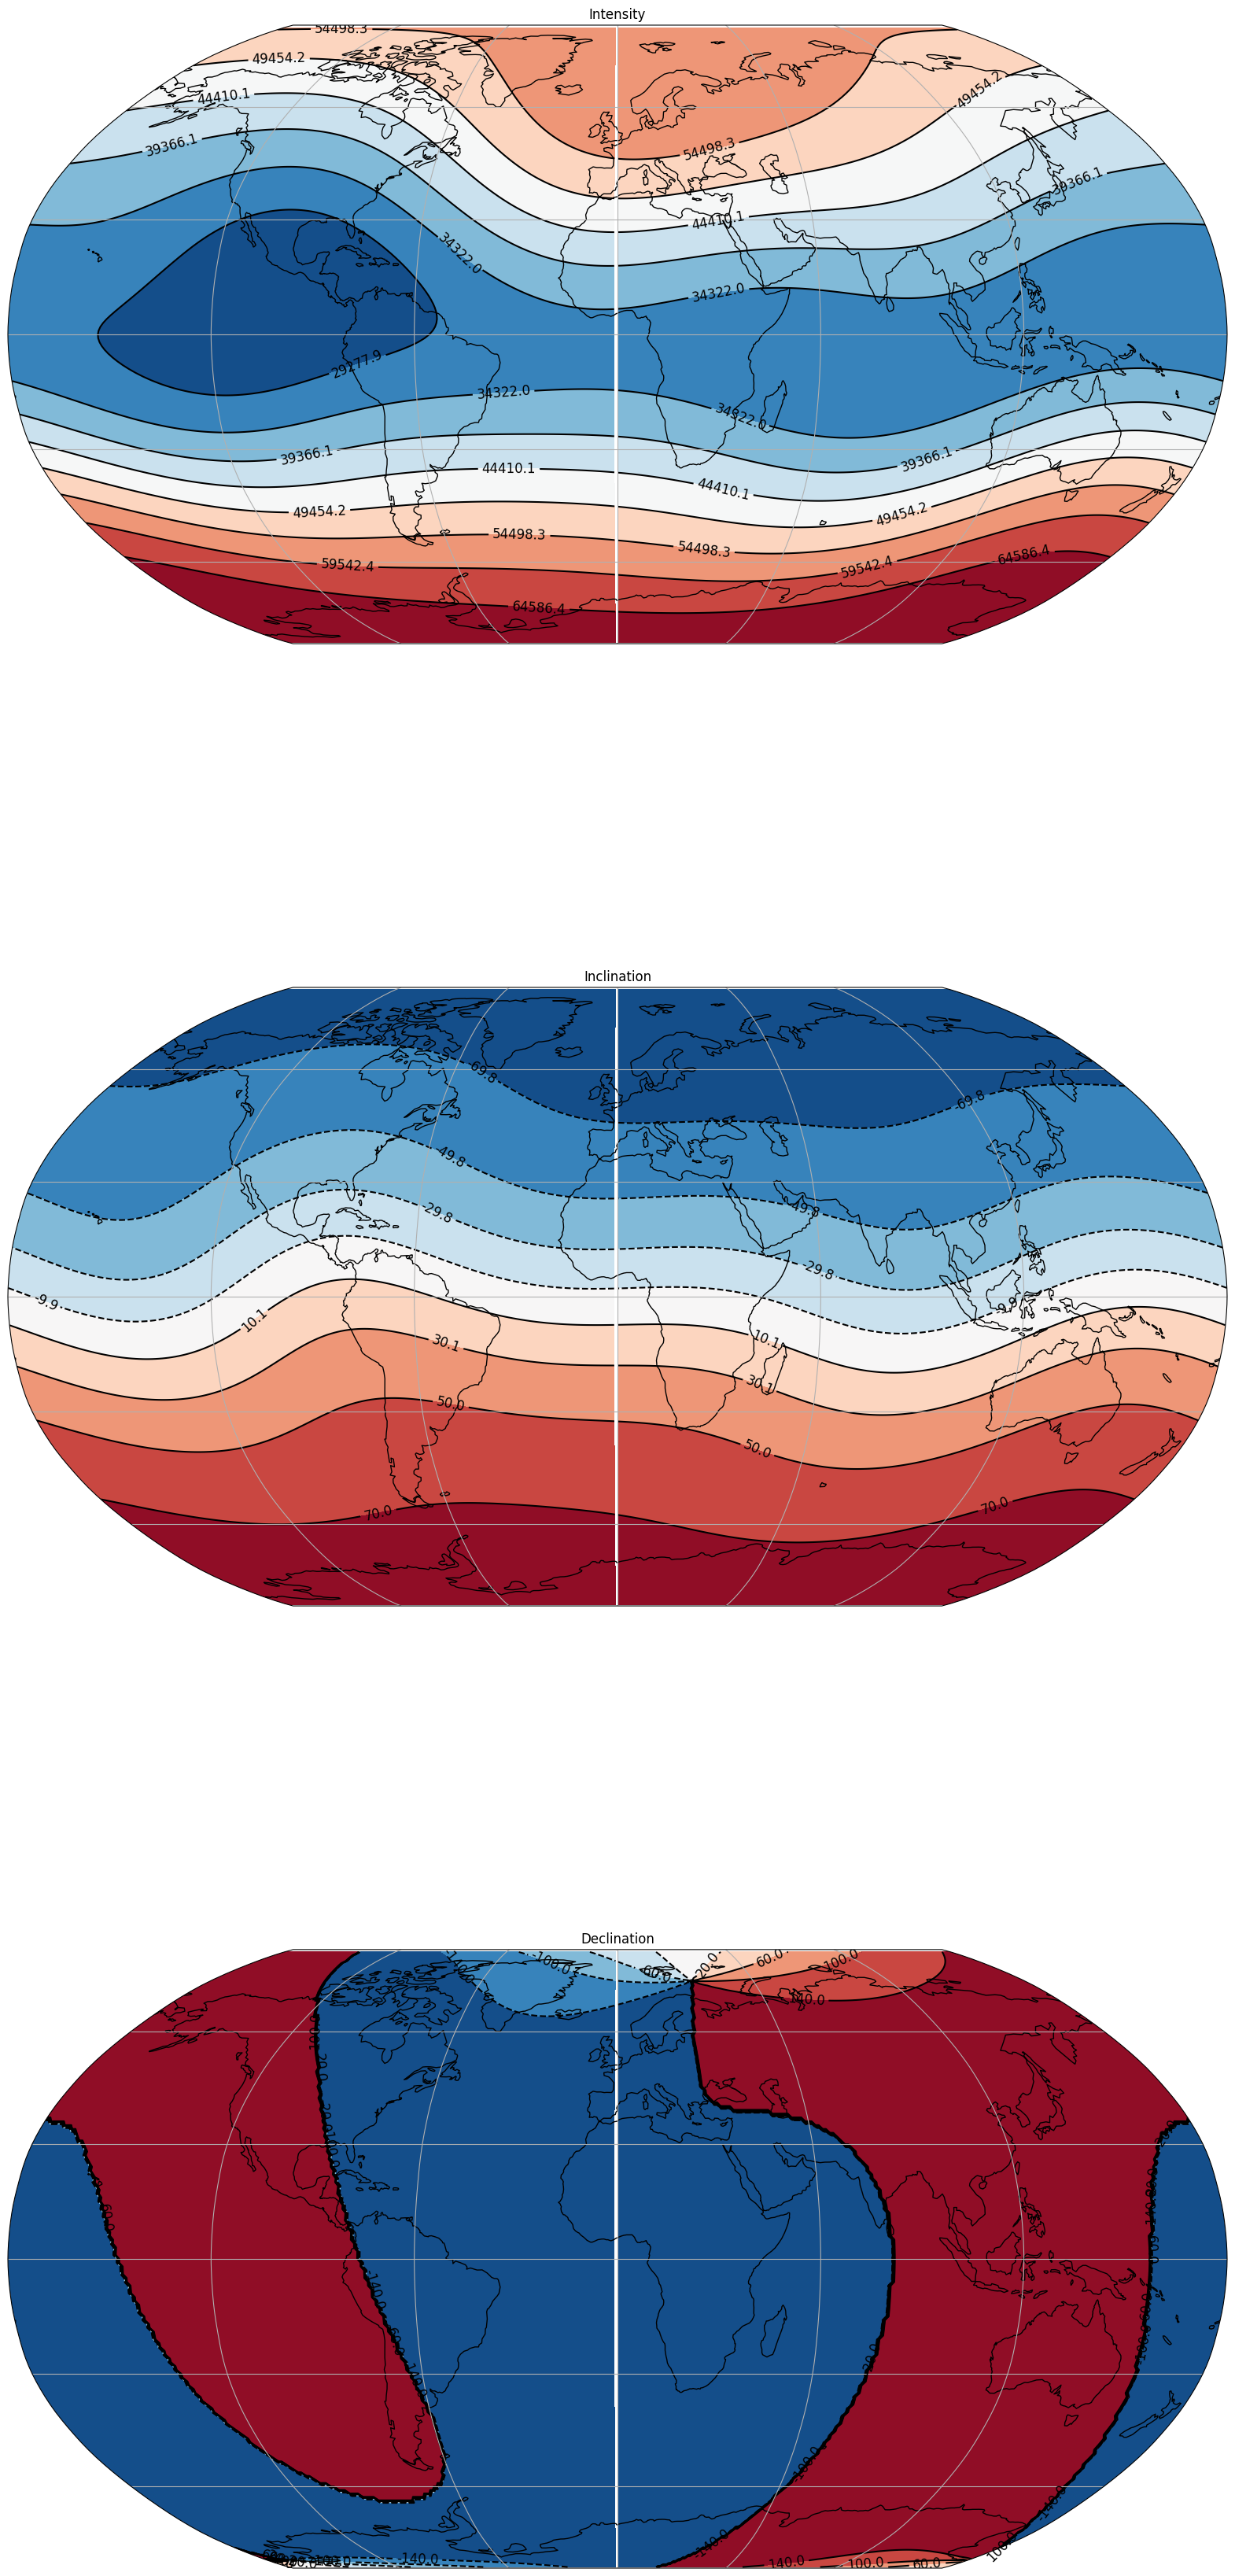

In [26]:
# set three axes and apply a Robinson world projection
fig, axes = plt.subplots(nrows=3, figsize=(20, 45), subplot_kw={'projection': ccrs.Robinson()})
# call the function; input axes and inversion class, but also wished projection, plot time, and optional plotting keywords
axes = plot_tools.plot_worldmag(axes, test_inv, proj=ccrs.PlateCarree(), plot_loc=True, time=-8000)
plt.show()

In [27]:
# clear memory and delete instance of class
del test_inv

## 3. Sweeping through models to find optimal damping parameters (optional)
Normally we do not have the optimal damping parameters yet, which is why we will have to search for them **now**. 
We will start a new class and add all our data, then we will sweep through a range of spatial and temporal damping parameters. By plotting model size versus residuals, we will find the best fitting parameters.

In [28]:
# set class and add data
sweep_inv = FieldInversion(t_min=-8000, t_max=1990, t_step=39.8007968127486, maxdegree=3)
sweep_inv.prepare_inversion(inputdata, spat_type='ohmic_heating', temp_type='min_acc')

#### *sweep_damping*
This method enables us to sweep through the parameters, it needs:
- `spatial_range`: the range of spatial damping parameters to be tested
- `temporal_range`: the range of temporal damping parameters to be tested
- `x0`: starting model of gaussian coefficients

Results will be saved to the path specified by `basedir`. We will use 10 iterations per inversion.

In [29]:
spatial_range = np.logspace(-15, -11, 5)
temporal_range = np.logspace(-4, 0, 5)
x0 = np.zeros(sweep_inv._nr_coeffs)
x0[0] = 30000

sweep_inv.sweep_damping(x0, spatial_range, temporal_range, basedir= path / 'output', max_iter=10)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:59<00:00, 95.97s/it]


After performing the calculations, we can plot the results of the damping parameters with `plot_tools.plot_sweep`. The best model would be the model that produces a low residual and a small model size (=norm of the gaussian coefficients).

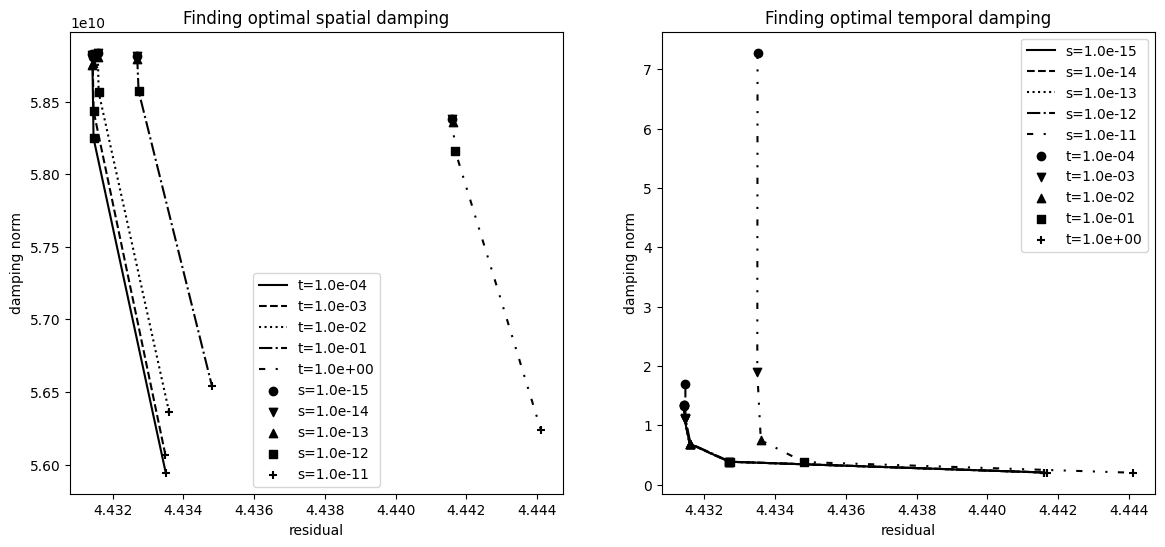

In [30]:
# Now we plot residual vs norm of the model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Finding optimal spatial damping')
axes[1].set_title('Finding optimal temporal damping')
# call function to plot lines
axes = plot_tools.plot_sweep(axes, spatial_range, temporal_range, basedir=path / 'output')
axes[0].legend()
axes[1].legend()
# define colors and a colorbar
plt.show()

#### conclusion
A spatial damping factor between 1e-13 and 1e-14 seems to be best; it results in both a low residual and small Gauss coefficients, so our initial assumption of 5e-13 was good enough. For the temporal damping factor, a damping factor of around 1e-3 seems optimal. We previously used 1e-1, so we could make our main model (see Section 2) even better!

In [31]:
# delete class
del sweep_inv

# to be added
1. Adding geomagia data
   - use `read_geomagia` in data_prep
2. Starting model with gauss coefficients
   - use `read_gauss` in file reader

## end of tutorial
This is the end of this tutorial, but we have not covered every detail. If you want to know more about a function, have a look at the code, or type the function with a questionmark after it to get more info (e.g. `plot_tools.plot_spectrum?`). Otherwise you can allways drop an email to Frenk Out at f.out@uu.nl or outfrenk@gmail.com.